In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
def load_dataset(csv_file_path):
    """Loads the dataset from a CSV file."""
    return pd.read_csv(csv_file_path)


In [4]:
def preprocess_image(image_path, target_size=(100, 100)):
    """Load and preprocess image: grayscale, resize, normalize."""
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image


In [5]:
def build_siamese_model(input_shape):
    """Builds the base network for the Siamese model."""
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    output_layer = Dense(128, activation='relu')(x)
    
    return Model(inputs=input_layer, outputs=output_layer)


In [6]:
def euclidean_distance(vectors):
    """Compute the Euclidean distance between feature vectors."""
    f1, f2 = vectors
    return K.sqrt(K.sum(K.square(f1 - f2), axis=1, keepdims=True))


In [7]:
def create_pairs(df, train_folder_path):
    """Creates image pairs and their corresponding labels from the CSV."""
    pairs = []
    labels = []
    
    for _, row in df.iterrows():
        img1 = preprocess_image(os.path.join(train_folder_path, row[0]))
        img2 = preprocess_image(os.path.join(train_folder_path, row[1]))
        pairs.append([img1, img2])
        labels.append(row[2])
        
    pairs = np.array(pairs)
    return [pairs[:, 0], pairs[:, 1]], np.array(labels)


In [8]:
def build_siamese_network(input_shape):
    """Builds the complete Siamese network with a distance computation layer."""
    base_network = build_siamese_model(input_shape)
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = Lambda(euclidean_distance)([processed_a, processed_b])
    
    model = Model([input_a, input_b], distance)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
    
    return model


In [9]:
def train_siamese_model(model, pairs, labels, epochs=10, batch_size=32):
    """Trains the Siamese model using the provided pairs and labels."""
    pairs[0] = np.expand_dims(pairs[0], axis=-1)
    pairs[1] = np.expand_dims(pairs[1], axis=-1)
    model.fit([pairs[0], pairs[1]], labels, epochs=epochs, batch_size=batch_size)


In [10]:
def verify_signature(model, test_image_path, reference_image_path, threshold=0.5):
    """Verifies if the test signature matches the reference signature."""
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    test_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=-1)
    reference_image = np.expand_dims(np.expand_dims(reference_image, axis=0), axis=-1)
    
    dist = model.predict([test_image, reference_image])[0][0]
    
    if dist > threshold:
        return "Test Signature is authentic."
    else:
        return "Test Signature is a forgery."


In [11]:
if __name__ == "__main__":
    # Paths
    csv_file_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\train_data.csv'
    train_folder_path = r'C:\Users\shiva\Downloads\nitk_intern\train'
    
    # Load dataset
    df = load_dataset(csv_file_path)
    
    # Define input shape
    input_shape = (100, 100, 1)
    
    # Build and compile the model
    siamese_model = build_siamese_network(input_shape)
    
    # Create pairs from the CSV
    pairs, labels = create_pairs(df, train_folder_path)
    
    # Train the model
    train_siamese_model(siamese_model, pairs, labels, epochs=10, batch_size=32)



Epoch 1/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 377s 513ms/step - accuracy: 0.9321 - loss: 0.0717
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 365s 503ms/step - accuracy: 0.9999 - loss: 0.0054
Epoch 3/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 1894s 3s/step - accuracy: 0.9997 - loss: 0.0073
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 370s 510ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 5/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 364s 501ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 374s 515ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 7/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 369s 509ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 8/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 372s 513ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 9/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 369s 508ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 10/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 371s 510ms/step - accuracy: 1.0000 - loss: 0.0015


In [15]:
from tensorflow.keras.models import load_model

# Load your trained model (assuming you have it in memory already)
trained_model = siamese_model  # Replace with your trained model variable

# Specify the path where you want to save the model
model_save_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5'

# Save the trained model
trained_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5


In [18]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocessing function (reuse from the training phase)
def preprocess_image(image_path, target_size=(100, 100)):
    """Load and preprocess image: grayscale, resize, normalize."""
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Verify signature function (reuse from the training phase)
def verify_signature(model, test_image_path, reference_image_path, threshold=0.5):
    """Verifies if the test signature matches the reference signature."""
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    test_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=-1)
    reference_image = np.expand_dims(np.expand_dims(reference_image, axis=0), axis=-1)
    
    dist = model.predict([test_image, reference_image])[0][0]
    
    return dist > threshold

# Load the trained model
model_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5'  # Replace with the actual path to your trained model
siamese_model = load_model(model_path, custom_objects={'euclidean_distance': euclidean_distance})

# Load the test dataset CSV
test_csv_file_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\test_data.csv'  # Replace with the path to your test CSV file
test_df = pd.read_csv(test_csv_file_path)

# Paths for test images (set the root directory of your test images)
test_image_root = r'C:\Users\shiva\Downloads\nitk_intern\test'  # Replace with the root path of your test images

# Initialize counters for accuracy calculation
correct_predictions = 0
total_predictions = len(test_df)

# Iterate through the test dataset and verify each signature pair
for index, row in test_df.iterrows():
    test_image_path = os.path.join(test_image_root, row[0])
    reference_image_path = os.path.join(test_image_root, row[1])
    label = row[2]
    
    # Predict if the signature is authentic or a forgery
    prediction = verify_signature(siamese_model, test_image_path, reference_image_path, threshold=0.5)
    
    # Check if the prediction matches the label
    if (prediction and label == 1) or (not prediction and label == 0):
        correct_predictions += 1

# Calculate and print the accuracy
accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

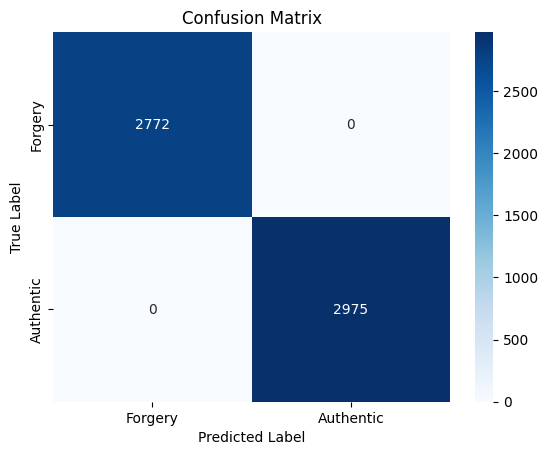

Classification Report:
              precision    recall  f1-score   support

     Forgery       1.00      1.00      1.00      2772
   Authentic       1.00      1.00      1.00      2975

    accuracy                           1.00      5747
   macro avg       1.00      1.00      1.00      5747
weighted avg       1.00      1.00      1.00      5747



In [19]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing function (reuse from the training phase)
def preprocess_image(image_path, target_size=(100, 100)):
    """Load and preprocess image: grayscale, resize, normalize."""
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Verify signature function (reuse from the training phase)
def verify_signature(model, test_image_path, reference_image_path, threshold=0.5):
    """Verifies if the test signature matches the reference signature."""
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    test_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=-1)
    reference_image = np.expand_dims(np.expand_dims(reference_image, axis=0), axis=-1)
    
    dist = model.predict([test_image, reference_image])[0][0]
    
    return dist > threshold

# Load the trained model
model_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5'
siamese_model = load_model(model_path, custom_objects={'euclidean_distance': euclidean_distance})

# Load the test dataset CSV
test_csv_file_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\test_data.csv'
test_df = pd.read_csv(test_csv_file_path)

# Paths for test images
test_image_root = r'C:\Users\shiva\Downloads\nitk_intern\test'

# Initialize lists to hold predictions and true labels
y_true = []
y_pred = []

# Iterate through the test dataset and verify each signature pair
for index, row in test_df.iterrows():
    test_image_path = os.path.join(test_image_root, row[0])
    reference_image_path = os.path.join(test_image_root, row[1])
    label = row[2]
    
    # Predict if the signature is authentic or a forgery
    prediction = verify_signature(siamese_model, test_image_path, reference_image_path, threshold=0.5)
    
    # Store the results
    y_true.append(label)
    y_pred.append(1 if prediction else 0)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Authentic'], yticklabels=['Forgery', 'Authentic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Forgery', 'Authentic']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Test Signature is authentic.
Distance between signatures: 0.0466


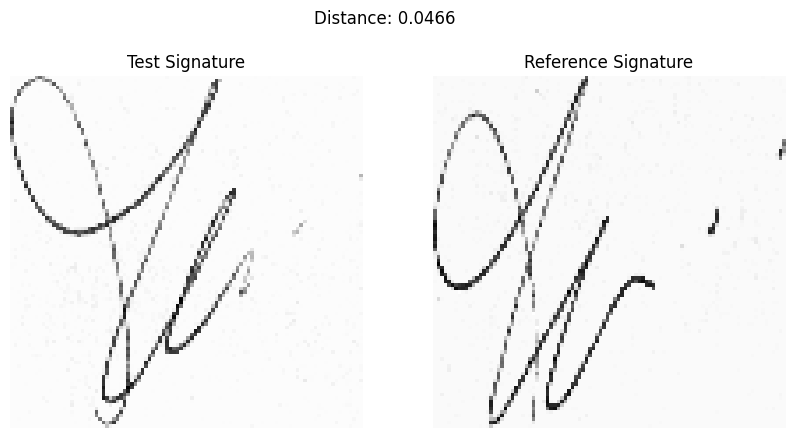

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K

# Preprocessing function (reuse from the training phase)
def preprocess_image(image_path, target_size=(100, 100)):
    """Load and preprocess image: grayscale, resize, normalize."""
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Define Euclidean distance function
def euclidean_distance(vectors):
    (f1, f2) = vectors
    dist = K.sqrt(K.sum(K.square(f1 - f2), axis=1, keepdims=True))
    return dist

# Verify signature function (reuse from the training phase)
def verify_signature(model, test_image_path, reference_image_path, threshold=0.5):
    """Verifies if the test signature matches the reference signature."""
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    test_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=-1)
    reference_image = np.expand_dims(np.expand_dims(reference_image, axis=0), axis=-1)
    
    dist = model.predict([test_image, reference_image])[0][0]
    
    is_authentic = dist <= threshold
    return is_authentic, dist

# Load the trained model
model_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5'  # Replace with the actual path to your trained model
siamese_model = load_model(model_path, custom_objects={'euclidean_distance': euclidean_distance})

if __name__ == "__main__":
    # Paths for testing
    test_image_path = r'C:\Users\shiva\Downloads\nitk_intern\test\049\11_049.png'
    reference_image_path = r'C:\Users\shiva\Downloads\nitk_intern\test\049\01_049.png'
    
    # Verify a test signature
    is_authentic, distance = verify_signature(siamese_model, test_image_path, reference_image_path, threshold=0.5)
    
    # Print the results
    if is_authentic:
        print("Test Signature is authentic.")
    else:
        print("Test Signature is a forgery.")
    
    print(f"Distance between signatures: {distance:.4f}")
    
    # Plot the images
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title('Test Signature')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reference_image.squeeze(), cmap='gray')
    plt.title('Reference Signature')
    plt.axis('off')
    
    plt.suptitle(f'Distance: {distance:.4f}')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


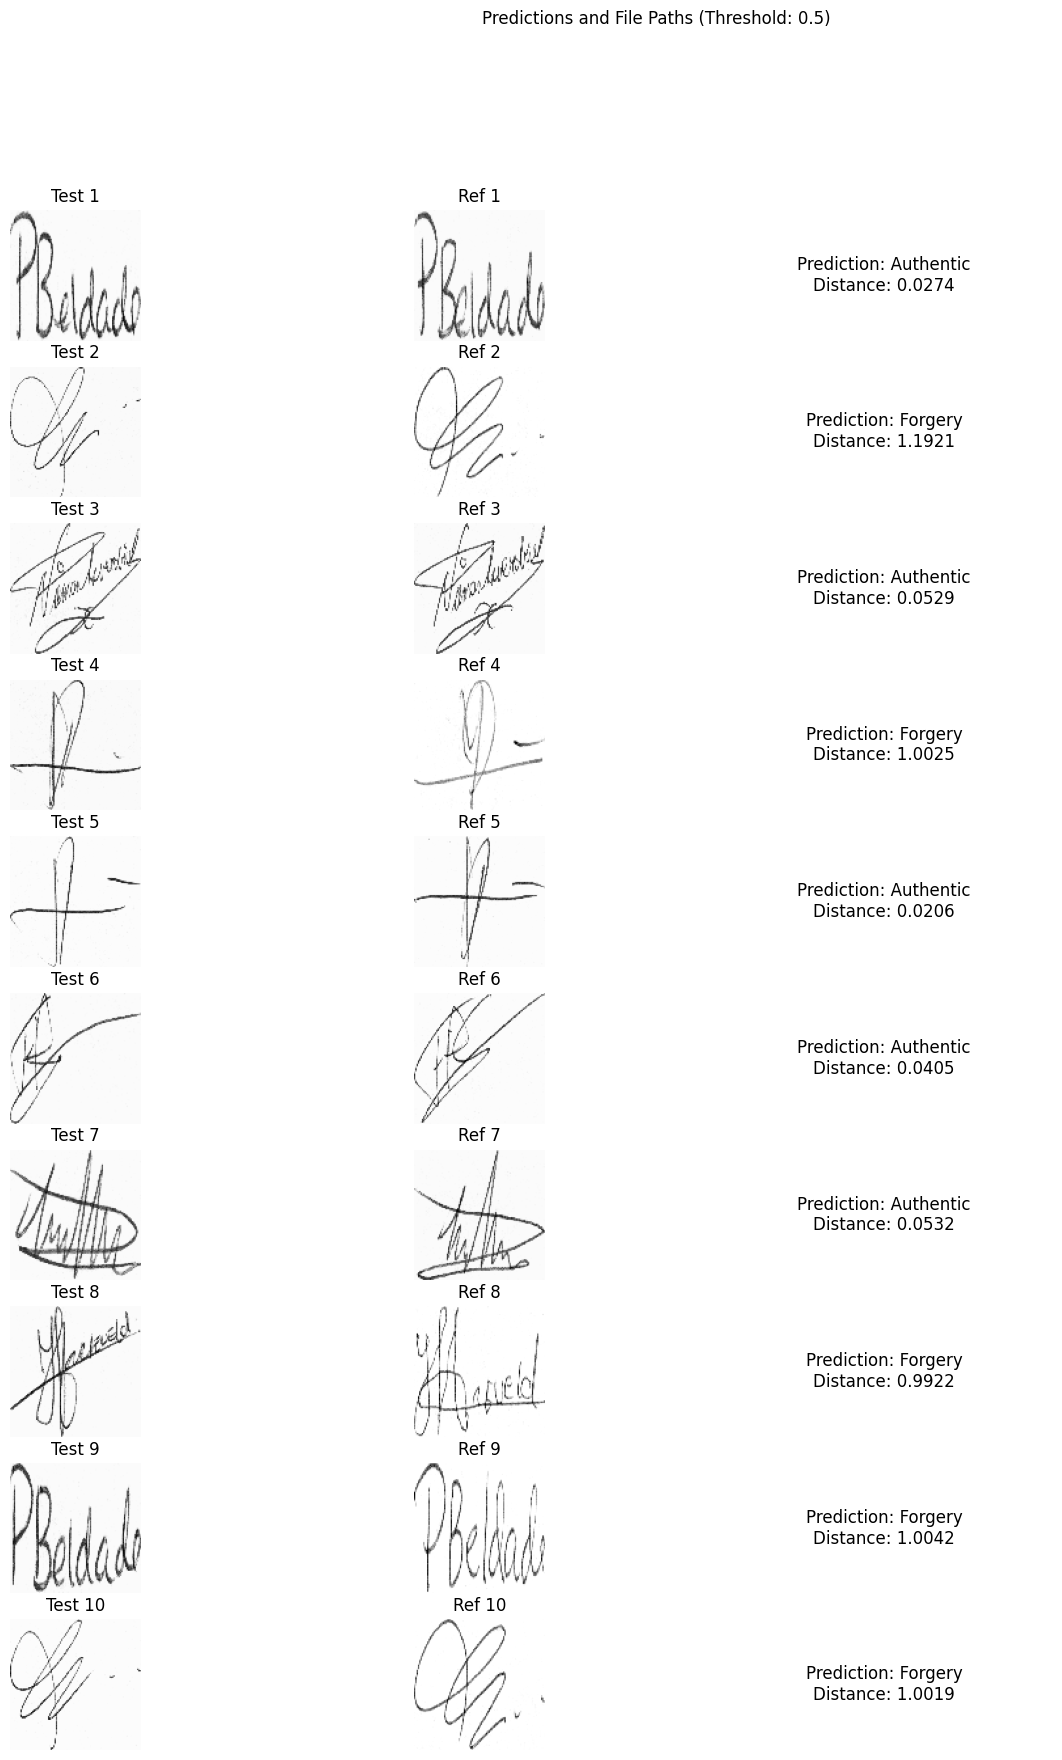

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K

# Define functions (reuse from previous code)
def preprocess_image(image_path, target_size=(100, 100)):
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    return image

def euclidean_distance(vectors):
    (f1, f2) = vectors
    dist = K.sqrt(K.sum(K.square(f1 - f2), axis=1, keepdims=True))
    return dist

def verify_signature(model, test_image_path, reference_image_path, threshold=0.5):
    test_image = preprocess_image(test_image_path)
    reference_image = preprocess_image(reference_image_path)
    
    test_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=-1)
    reference_image = np.expand_dims(np.expand_dims(reference_image, axis=0), axis=-1)
    
    dist = model.predict([test_image, reference_image])[0][0]
    is_authentic = dist <= threshold
    return is_authentic, dist

# Load the trained model
model_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\siamese_model.h5'
siamese_model = load_model(model_path, custom_objects={'euclidean_distance': euclidean_distance})

if __name__ == "__main__":
    # Load the test dataset CSV
    test_csv_file_path = r'C:\Users\shiva\OneDrive\Desktop\trans-trip\test_data.csv'
    test_df = pd.read_csv(test_csv_file_path)
    
    # Paths for test images
    test_image_root = r'C:\Users\shiva\Downloads\nitk_intern\test'
    
    # Select 10 random entries from the CSV
    random_entries = test_df.sample(10)
    
    plt.figure(figsize=(20, 20))
    
    for i, (_, row) in enumerate(random_entries.iterrows()):
        test_image_path = os.path.join(test_image_root, row[0])
        reference_image_path = os.path.join(test_image_root, row[1])
        true_label = row[2]
        
        # Verify the selected signature
        is_authentic, distance = verify_signature(siamese_model, test_image_path, reference_image_path, threshold=0.5)
        
        # Plot images and file paths
        plt.subplot(10, 4, i*4+1)
        plt.imshow(preprocess_image(test_image_path).squeeze(), cmap='gray')
        plt.title(f'Test {i+1}')
        plt.axis('off')
        plt.xlabel(f'Path: {row[0]}')

        plt.subplot(10, 4, i*4+2)
        plt.imshow(preprocess_image(reference_image_path).squeeze(), cmap='gray')
        plt.title(f'Ref {i+1}')
        plt.axis('off')
        plt.xlabel(f'Path: {row[1]}')

        # Display prediction result and distance
        plt.subplot(10, 4, i*4+3)
        plt.text(0.5, 0.5, f'Prediction: {"Authentic" if is_authentic else "Forgery"}\nDistance: {distance:.4f}',
                 fontsize=12, ha='center', va='center')
        plt.axis('off')
    
    plt.suptitle(f'Predictions and File Paths (Threshold: 0.5)')
    plt.show()
